# Hydrogen content calculator for FeHx alloy

Ref: Piet et al. 2023

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [16]:
import matplotlib
# if you have helvetical installed for matplotlib
# you may uncomment the following lines
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#plt.rcParams['font.family'] = 'Helvetica'

You need to have `pytheos` installed.  

```bash
pip install pytheos
```

In [17]:
import numpy as np
import pandas as pd
import pytheos as eos
from collections import OrderedDict
import scipy.constants as constants

## Data from Piet et al (2023)

Note that we did not include two phase fit results and dhcp in this notebook for simplicity.  However, complete dataset is provided in `./csv-piet/`.

In [19]:
# Import data
fcc = pd.read_csv('./csv-piet/FeNi-fcc.csv')
piet_data = {'fcc-FeNiHx': fcc}
piet_data['fcc-FeHx'] = pd.DataFrame(
    np.array([[26,26,86], [47.35885/4, 47.53133/4, 45.74738/4]]).T, columns = ['P', 'V'])
piet_label = {'fcc-FeNiHx': 'Piet2023-FeNiHx', 'fcc-FeHx': 'Piet2023-FeHx'}

## DFT calibrations from Piet et al. (2023)

In [5]:
dft_v0 = {'hcp-Fe': 10.257, 'fcc-Fe': 10.644, 'FM-FeH3': 18.043}
dft_k0 = {'hcp-Fe': 289, 'fcc-Fe': 172.4, 'FM-FeH3': 179.3}
dft_k0p = {'hcp-Fe': 4.51, 'fcc-Fe': 6.91, 'FM-FeH3': 4.26}

p_dft = np.linspace(0, 100, 101)

dft_color = {'hcp-Fe': 'k', 'fcc-Fe': '#22621C', 'FM-FeH3': 'k'}
dft_molH = {'hcp-Fe': 0, 'fcc-Fe': 0, 'FM-FeH3': 3}
dft_label = {'hcp-Fe': 'x = 0 (hcp)', 'fcc-Fe': 'x = 0 (fcc)',
         'FM-FeH3': 'x = 3 = 1(O) + 2(T)'}

dft_ls = {}
for key in dft_molH:
    dft_ls[key] = '-'

## Functions

In [6]:
#v0_std = 11.21; k0_std = 163.4; k0p_std = 5.38

def delV_exp(p, v):
    """
    calculate Delta V for experiments. fcc volume is from Dorogokupets 2019
    p = experimental pressure
    v = unit-cell volume per Fe
    """
    v_dorogo = eos.vinet_v(p, 6.9285/constants.N_A/1.e-24, 
                           146.2, 4.67)
    delV = v - v_dorogo
    return delV

def v_dft(p, model='FM-FeH3'):
    vol_dft = eos.vinet_v(p, dft_v0[model], dft_k0[model], dft_k0p[model])
    return vol_dft
    
def delV_dft(p, model='FM-FeH3'):
    """
    calculate Delta V for DFT. 
    p = pressure
    """
    v = v_dft(p, model=model)
    v_std = v_dft(p, model='fcc-Fe')
    return v - v_std

def delVH_dft(p, model='FM-FeH3'):
    """
    calculate Delta V_H from DFT
    p = pressure
    models should be 'FM-FeH1.5-OT', 'FM-FeH2-OT', 'FM-FeH3'
    """
    return delV_dft(p, model=model) / dft_molH[model]

def cal_H_to_Fe(p, v_exp, model='FM-FeH3'):
    """
    calculate H content
    p = experimental pressure
    v_exp = experimental volume
    """
    delVH = delVH_dft(p, model=model)
    return delV_exp(p, v_exp) / delVH 

## Other experimental datasets

In [7]:
other_data = {}
other_data_FeNi = {}

In [8]:
other_data['tagawa2022'] = pd.read_csv('./csv-others/fcc-FeH-tagawa2022.csv')
other_data['narygina2011'] = pd.read_csv('./csv-others/fcc-FeH-narygina2011.csv')
other_data['thompson2018'] = pd.read_csv('./csv-others/fcc-FeH-thompson18.csv')
other_data['ikuta2019'] = pd.read_csv('./csv-others/fcc-FeH-ikuta19.csv')
other_data['kato2020'] = pd.read_csv('./csv-others/fcc-FeH-kato20.csv')
other_data['kato2020'].V = other_data['kato2020'].V * 4.
other_data['ohta2019'] = pd.DataFrame(
    np.array([[65, 34, 48, 39], [44.51,46.13,44.95,43.27]]).T, columns = ['P', 'V'])
other_data_FeNi['ohta2019'] = pd.DataFrame(
    np.array([[47.], [46.21]]).T, columns = ['P', 'V'])
other_data_FeNi['shibazaki2014'] = pd.DataFrame(
    np.array([[1.90,4.22,9.60], [45.78,46.33,50.33]]).T, columns = ['P', 'V'])

In [9]:
other_shape = {'tagawa2022': 'o', 'narygina2011': 'd', 
               'thompson2018': '^', 'ikuta2019': 'v', 'kato2020': 'h',
              'ohta2019': 's'}
other_shape_FeNi = {'ohta2019': 's', 'shibazaki2014': 'o'}

## Make plot

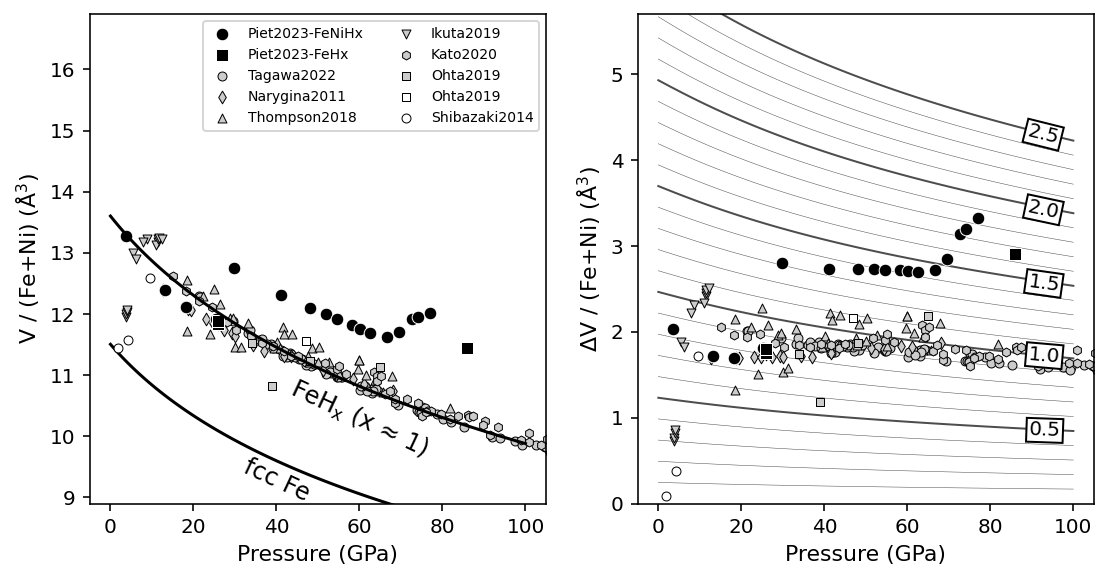

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
# symbol sizes
s_ours = 80 
s_piet = 40
s_others = 20

###################################################
# Piet data
# atomic volume
axs[0].scatter(piet_data['fcc-FeNiHx'].P, piet_data['fcc-FeNiHx'].V/4, 
        marker='o', c='k', edgecolor='w', s=s_piet, linewidth=.5,
        label=piet_label['fcc-FeNiHx'], zorder=2)
axs[0].scatter(piet_data['fcc-FeHx'].P, piet_data['fcc-FeHx'].V, 
        marker='s', c='k', edgecolor='w', linewidth=.5, s=s_piet, 
        label=piet_label['fcc-FeHx'], zorder=2) 
# volume difference
axs[1].scatter(piet_data['fcc-FeNiHx'].P, delV_exp(piet_data['fcc-FeNiHx'].P, 
                                              piet_data['fcc-FeNiHx'].V / 4.), 
            c='k', edgecolor='w', linewidth=.5, s=s_piet, zorder=2,
           label=piet_label['fcc-FeNiHx']) # fcc-FeNiH 
#print(delV_exp(our_data['fcc-FeNiH'].P, our_data['fcc-FeNiH'].V))
axs[1].scatter(piet_data['fcc-FeHx'].P, delV_exp(piet_data['fcc-FeHx'].P, 
                                              piet_data['fcc-FeHx'].V), 
            marker='s', c='k', label=piet_label['fcc-FeHx'],
            edgecolor='w', linewidth=.5, s=s_piet, zorder=2) 

####################################################
## Dorogokupets, Kato fcc EOS
p_std = np.linspace(0,100,100)
v_dorogo = eos.vinet_v(p_std, 6.9285/constants.N_A/1.e-24, 
                       146.2, 4.67)
axs[0].plot(p_std, v_dorogo, 'k-')#, label='Dorogokupets 2017')
# Kato
axs[0].plot(p_std, eos.vinet_v(p_std, 2.097, 301.2, 1.404) + v_dorogo, 
            'k-') #, label='Kato 20xx')

####################################################
## Data from the literature
# atomic volume
for key in other_data:
    axs[0].scatter(other_data[key].P, other_data[key].V/4, marker=other_shape[key], 
        c='#cccccc', alpha=1, edgecolor='k', linewidth=.5, s=s_others, 
        label=key.capitalize(), zorder=0)
for key in other_data_FeNi:
    axs[0].scatter(other_data_FeNi[key].P, other_data_FeNi[key].V/4, 
        marker=other_shape_FeNi[key], c='w', alpha=1, edgecolor='k', 
        linewidth=.5, s=s_others, label=key.capitalize(), zorder=99)
# volume difference
for key in other_data:
    axs[1].scatter(other_data[key].P, delV_exp(other_data[key].P, other_data[key].V / 4.), 
        marker=other_shape[key], c='#cccccc', alpha=1, edgecolor='k', linewidth=.5, 
        s=s_others, label=key.capitalize(), zorder=0)
for key in other_data_FeNi:
    axs[1].scatter(other_data_FeNi[key].P, delV_exp(other_data_FeNi[key].P, 
                                                    other_data_FeNi[key].V / 4.), 
        marker=other_shape_FeNi[key], c='w', alpha=1, edgecolor='k', linewidth=.5, 
        s=s_others, label=key.capitalize(), zorder=0)

###################################################
## EOS from Piet DFT data (GGA)
key = 'FM-FeH3' #'FM-FeH1.5-OT'# 'FM-FeH2-OT' #'FM-FeH3'
for n in np.linspace(0, 2.5, 26):
    if n in [0.5,1.0, 1.5, 2.0, 2.5]:
        lw = 1.0
    else:
        lw = 0.25
    axs[1].plot(p_dft, delVH_dft(p_dft, model=key)*n, 
                                 c='0.3', ls='-', lw=lw, zorder=-1) #label='FM FeH$_3$'

axs[0].set_xlim([-5,105])
axs[0].set_ylim([8.9,16.9]) #13.9
axs[0].set_xlabel('Pressure (GPa)', size=11)
axs[0].set_ylabel('V / (Fe+Ni) (Å$^\mathdefault{3}$)', size=11)
axs[0].legend(fontsize=7, ncol=2, loc='upper right')
axs[1].set_ylim([0,5.7])
axs[1].set_xlim([-5,105])
axs[1].set_xlabel('Pressure (GPa)', size=11)
axs[1].set_ylabel('$\mathdefault{\Delta}$V / (Fe+Ni) (Å$^\mathdefault{3}$)', size=11)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

for xpos, ypos, angle, label in zip(97*np.ones(5), [0.97, 1.85, 2.7, 3.57, 4.45], 
                    [-2, -5, -8, -12, -14], 
                    ['0.5', '1.0', '1.5', '2.0', '2.5']):
#                    ['x=0.5', 'x = 1', 'x = 1.5', 'x = 2', 'x = 2.5']):
    txt = axs[1].text(xpos, ypos, label, ha='right', size=10, color='k',
                 va='top', rotation=angle, bbox=dict(facecolor='w', pad=1.2))
    
for xpos, ypos, angle, label in zip([40, 60], [9.7,11.], 
                    [-25, -25], 
                    ['fcc Fe', 'FeH$_\mathdefault{x}$ (x ≈ 1)']):
    txt = axs[0].text(xpos, ypos, label, ha='center', size=12, color='k',
                 va='top', rotation=angle)

plt.savefig('f-data.pdf', bbox_inches='tight')
plt.show()

## How to get x 

```python
cal_x_FeH(pressure, volume)
```

As demonstrated below, it works for a single volume data point.  However, you can also use this for numpy arrays.

In [11]:
def cal_x_FeH(pressure, volume):
    """
    volume should be atomic volume
    """
    return delV_exp(pressure, volume) / delVH_dft(pressure, model='FM-FeH3')

In [12]:
cal_x_FeH(77, 48.068/4.)

1.8392757374140971

In [13]:
cal_x_FeH(11., 51.98/4.)

0.9490350525809783

In [14]:
cal_x_FeH(11.,50.40/4.)

0.7795204407912442